# スマホAR機能を使った 「月着陸船ゲーム」を作る! チは着離船のチ。

## 着陸船の情報を格納する Python クラス

In [1]:
import numpy as np
from ipywidgets import GridspecLayout, Button, Layout
import math, queue, threading, time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

class lunar_launder: # 物理動作をつかさどるクラス
    def __init__(self, pos):
        self.position = pos          # 位置
        self.velocity = np.zeros(3)  # xyz速度
        #self.is_jetting = False      # Jet推進中か否か
    def update(self, acc):
        self.position = self.position + self.velocity # 位置を更新
        self.velocity = self.velocity + acc           # XYZ速度を更新

## matplotlib による着陸船の 3 次元位置(履歴)表示機能

In [2]:
class vis_in_matplot: # matplotlibでの表示をつかさどるクラス
    def __init__(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.ax.set_xlim([-15,15])
        self.ax.set_ylim([-15,15])
        self.ax.set_zlim([0, 30])
        self.ax.set_xlabel('X-axis',fontsize='large')
        self.ax.set_ylabel('Y-axis',fontsize='large')
        self.ax.set_zlabel('Z-axis',fontsize='large')
        self.q = self.ax.quiver(0, 0, 0, 0, 0, 1, alpha=0.1)
    def update(self, pos):
        X, Y, Z, U, V, W = np.concatenate([pos, [0, 0, 1]])
        self.q = self.ax.quiver(X, Y, Z, U, V, W, alpha=0.1)

## iOS/iPadOS機能を使った、着陸船の 3 次元位置(履歴)表示機能

iOS/iPad 用のPython環境 Carnets for Jupyter で利用してください

In [ ]:
import arkit.arkit_sensor_ar_ex as ar
from objc_util import *
from defines import *

class vis_in_ARKit:
    def __init__(self):
        self.arview = ar.MyARView()
        self.arview.initScene()
        self.node = self.arview.loadSceneAndAdd('scn/LunarLander.scn')
        self.node.setScale((1.0, 1.0, 1.0))
        scr = ar.get_screen_size()
        #elf.node.setPosition((i/10.0, 0.0, 0.0))
        self.arview.initialize([0,0,scr.width,scr.height/2],True)
    def update(self, pos):
        X, Y, Z, U, V, W = np.concatenate([pos, [0, 0, 1]])
        self.node.setPosition((X, Z, Y))　# ARkitのZ軸は奥行き
    def close(self):
        self.arview.close_view()

## 垂直方向や左右方向へのジェット噴射をリアルタイムに行う制御ボタンを表示する処理

In [3]:
label = [["","⬆️",""],["⬅️","🔥","➡️"],["","⬇️",""]]
def create_button(description, style):
    return Button( description = description, button_style = style, 
                   layout=Layout(height='auto', width='auto') )
def button_event_handler(btn):
    for i in range(int(0.5/time_step_in_seconds)):     
        control_queue.put(np.array(btn.value)) #「与える力」キューに追加
def make_buttons(grid):
    grid = GridspecLayout(3, 3)
    for i, y in enumerate([1, 0, -1]):
        for j, x in enumerate([-1, 0, 1]):
            grid[i,j] = create_button(label[i][j],'warning')
            if i==1 and j==1:
                grid[i,j].value = np.array([0,0,0.02])
            elif (i+j)%2==0:
                grid[i,j].value = np.array([0,0,0])
            else:
                grid[i,j].value = np.array([x,y,0])
            grid[i,j].on_click(button_event_handler)
    return grid

## 運動方程式を使い着陸船の動きを刻々と計算し、リアルタイム表示する関数や変数設定

<IPython.core.display.Javascript object>


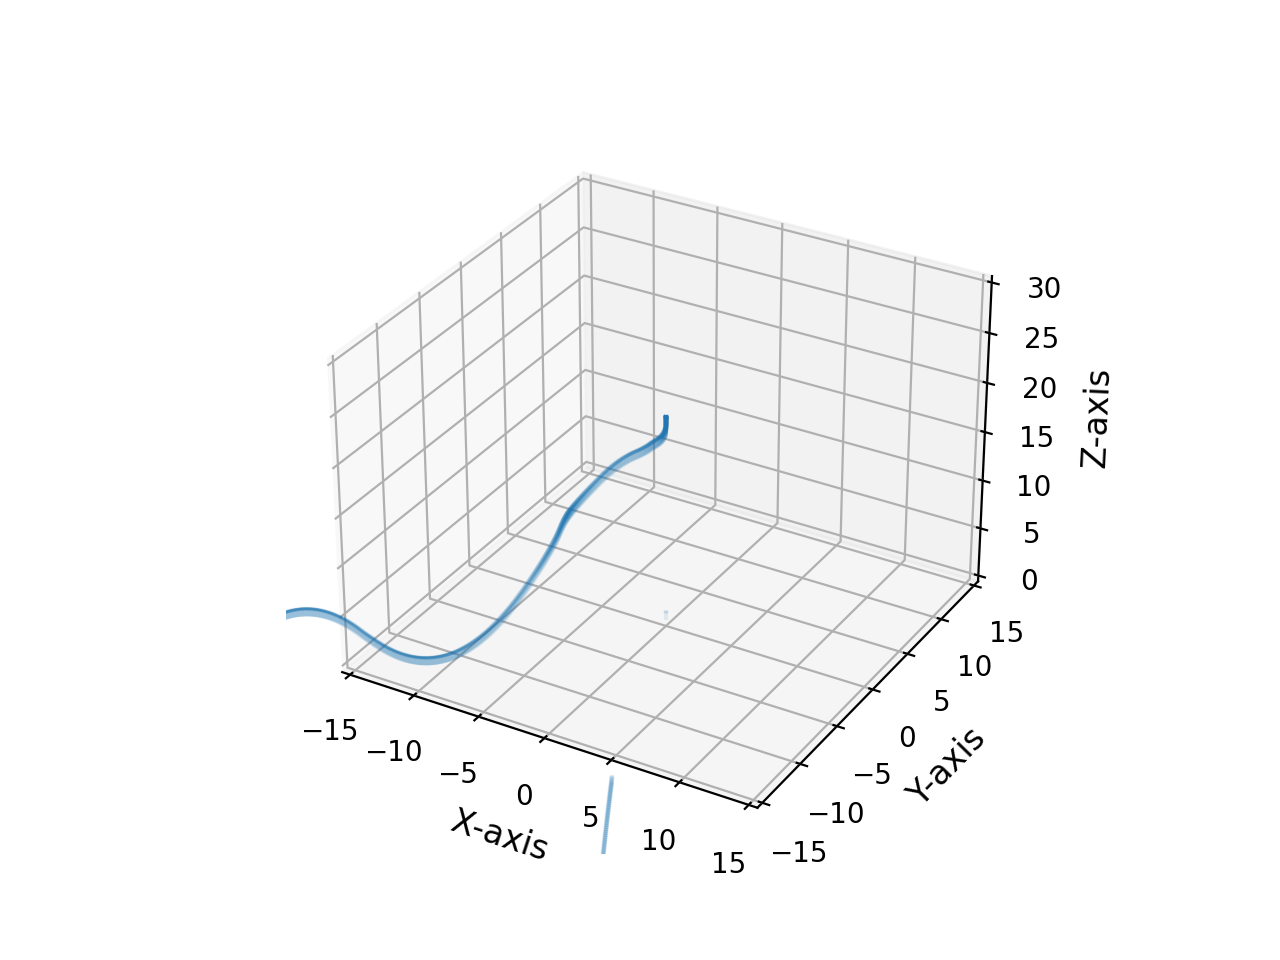

GridspecLayout(children=(Button(button_style='warning', layout=Layout(grid_area='widget001', height='auto', wi…

In [8]:
USE_AR = True   
control_queue = queue.Queue() # 動作命令=与える力キュー
g = np.array([0,0,-9.8*0.0001])
time_step_in_seconds=0.05
time_limit_in_seconds=100.0
n = int(time_limit_in_seconds/time_step_in_seconds)
m = 50

def sim(my_lunar_launder, control_queue, my_vis_in_matplot):
    for i in range(n):
        acc = g
        if not control_queue.empty():
            acc = (acc+control_queue.get()/m)*time_step_in_seconds
        my_lunar_launder.update(acc)
        my_vis.update(my_lunar_launder.position)
        time.sleep(time_step_in_seconds)
    if USE_AR:
        my_vis.close()
my_lunar_launder = lunar_launder(np.array([0,0,20]))
my_vis = vis_in_ARKit() if USE_AR else vis_in_matplot()
thread_phys = threading.Thread(target=sim,
    args=(my_lunar_launder, control_queue, my_vis,))
thread_phys.start()
grid = None; make_buttons(grid)

## 実行コード

In [1]:
import arkit.arkit_sensor_ar_ex as ar
#import uikit.ui_uiview as uiview
from objc_util import *
from defines import *
import time


# ARViewを作る
arview = ar.MyARView()
# シーンを作る
#arview.createSampleScene()
arview.initScene()
node = arview.loadSceneAndAdd('scn/LunarLander.scn')
# delegate作成・画面作成など
scr = ar.get_screen_size()
arview.initialize([0,0,scr.width,scr.height/2],True)

for i in range(60):
    #v.add_element(
    #    'sphere',[1,0,1,0.7], 0.02, 0.4, 0.5)
    if i%2 == 0:
        node.setScale((1.0, 1.0, 1.0))
    else:
        node.setScale((1.2, 1.2, 1.2))
    node.setPosition((i/10.0, 0.0, 0.0))
    time.sleep(0.5)
            
arview.close_view()

ARFrameSemanticSmoothedSceneDepth is enabled.
ARFrameSemanticSceneDepth is enabled.
c_void_p(10772401072)
c_void_p(10772514880)
1920
192
data append.
done
